In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from scipy.signal import convolve2d

In [3]:
image = data.coins()

In [5]:
def convolve(image):
    k_sobel_x = np.array((
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]),
        dtype="int")
    k_sobel_y = np.array((
        [ 1,  2,  1],
        [ 0,  0,  0],
        [-1, -2, -1]),
        dtype="int")
    image_x = convolve2d(image, k_sobel_x, mode="same")
    image_y = convolve2d(image, k_sobel_y, mode="same")
    img_edge = (image_y ** 2 + image_x ** 2) ** .5
    return img_edge

In [9]:
img_edge = convolve(image)

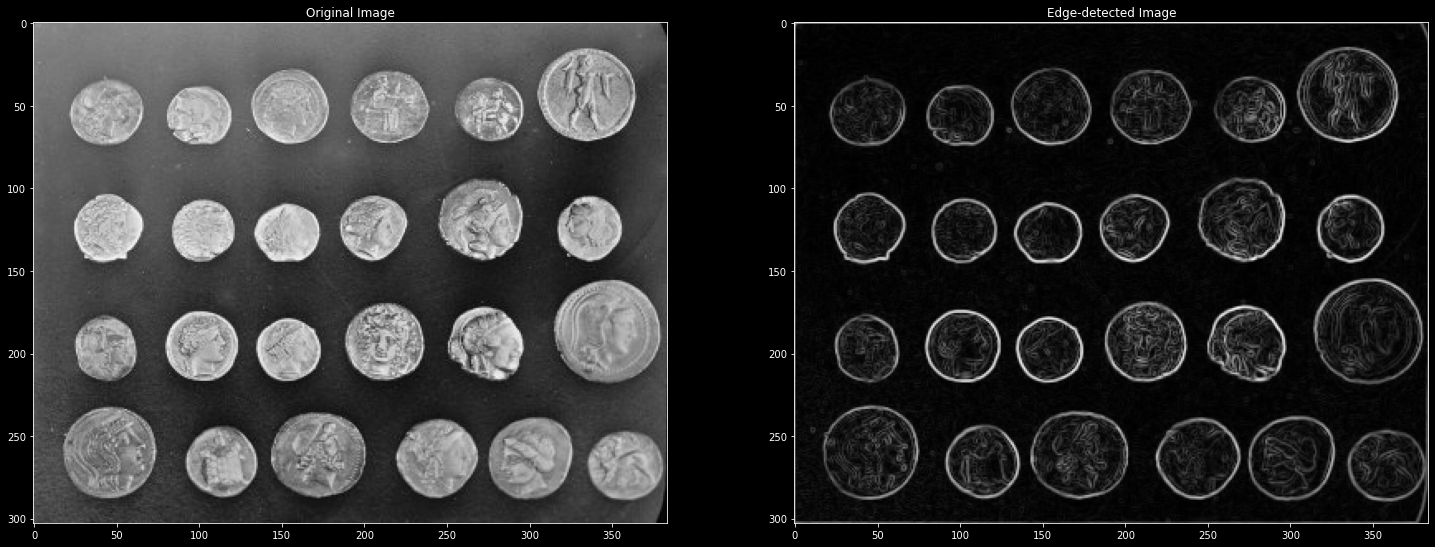

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))
axes[0].imshow(image, cmap="gray")
axes[0].title.set_text("Original Image")
axes[1].imshow(img_edge, cmap="gray")
axes[1].title.set_text("Edge-detected Image")

In [20]:
image_stack = np.dstack([image, img_edge])

In [23]:
image_stack.shape

(303, 384, 2)

In [24]:
dataframe = image_stack.reshape(-1, 2)

In [30]:
print(dataframe)
print("shape: ", dataframe.shape)
n_sample, n_feature = dataframe.shape

[[ 47.         510.88159098]
 [123.         571.70971655]
 [133.         577.10484316]
 ...
 [  4.          26.30589288]
 [ 10.          28.46049894]
 [  7.          35.4682957 ]]
shape:  (116352, 2)


In [32]:
k = 3
idx = np.random.choice(np.arange(n_sample), k)

In [34]:
centers = dataframe[idx]
print(centers)

[[63.         44.18144407]
 [29.         12.16552506]
 [87.         11.66190379]]


Text(0, 0.5, 'edge score')

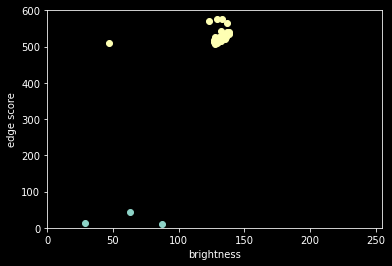

In [47]:
plt.scatter(centers[:, 0], centers[:, 1])
plt.scatter(dataframe[:50, 0], dataframe[:50, 1])
plt.xlim([0, 255])
plt.ylim([0, 600])
plt.xlabel("brightness")
plt.ylabel("edge score")

In [70]:
def distance(pt1, pt2):
    return ((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2) ** .5

def assignment(signals, centers):
    n = len(signals)
    k = len(centers)
    distances = np.zeros((n, k))
    for i, signal in enumerate(signals):
        for j, center in enumerate(centers):
            distances[i, j] = distance(signal, center)
    which_cluster = np.argmin(distances, axis=1)
    return which_cluster

def update(signals, which_cluster, k):
    n_samples, n_features = signals.shape
    new_centers = np.zeros((k, n_features))
    for i in range(k):
        new_centers[i] = signals[which_cluster == i].mean(axis=0)
    return new_centers

def kmeans(image, k, n_iter):
    h, w, c = image.shape
    signals = image.reshape(h * w, c).astype(int)
    n_sample, n_feature = signals.shape
    idx = np.random.choice(np.arange(n_sample), k)
    centers = signals[idx]
    for _ in range(n_iter):
        which_cluster = assignment(signals, centers)
        centers = update(signals, which_cluster, k)
    image_cluster = which_cluster.reshape((h, w))
    return image_cluster, centers

In [68]:
which_cluster = assignment(dataframe, centers)
which_cluster

array([0, 0, 0, ..., 1, 1, 1])

In [76]:
image_cluster, centers = kmeans(image_stack, k=6, n_iter=5)

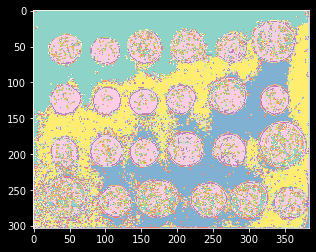

In [77]:
plt.imshow(image_cluster, cmap="Set3")

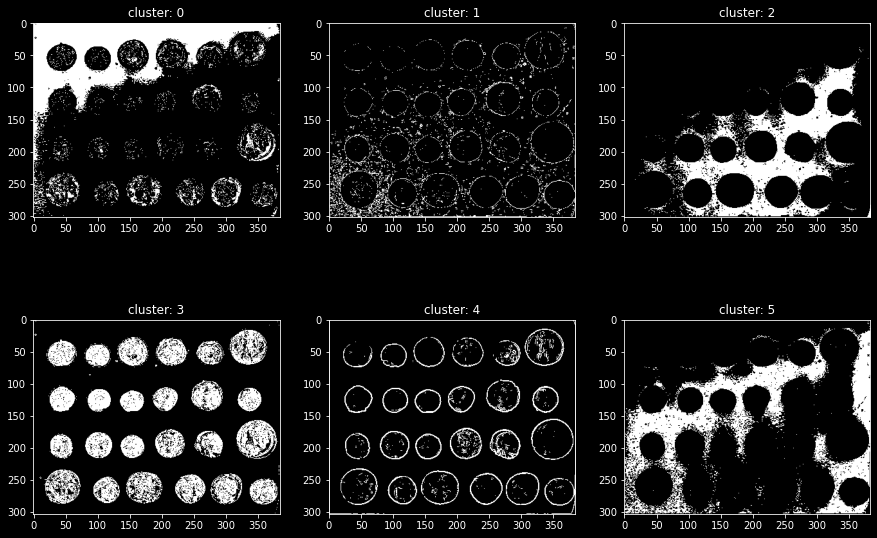

In [78]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
i = 0
for r in range(2):
    for c in range(3):
        if i < 10:
            axs[r, c].imshow(image_cluster == i, cmap="gray")
            axs[r, c].set_title("cluster: %d" % i)
        i += 1

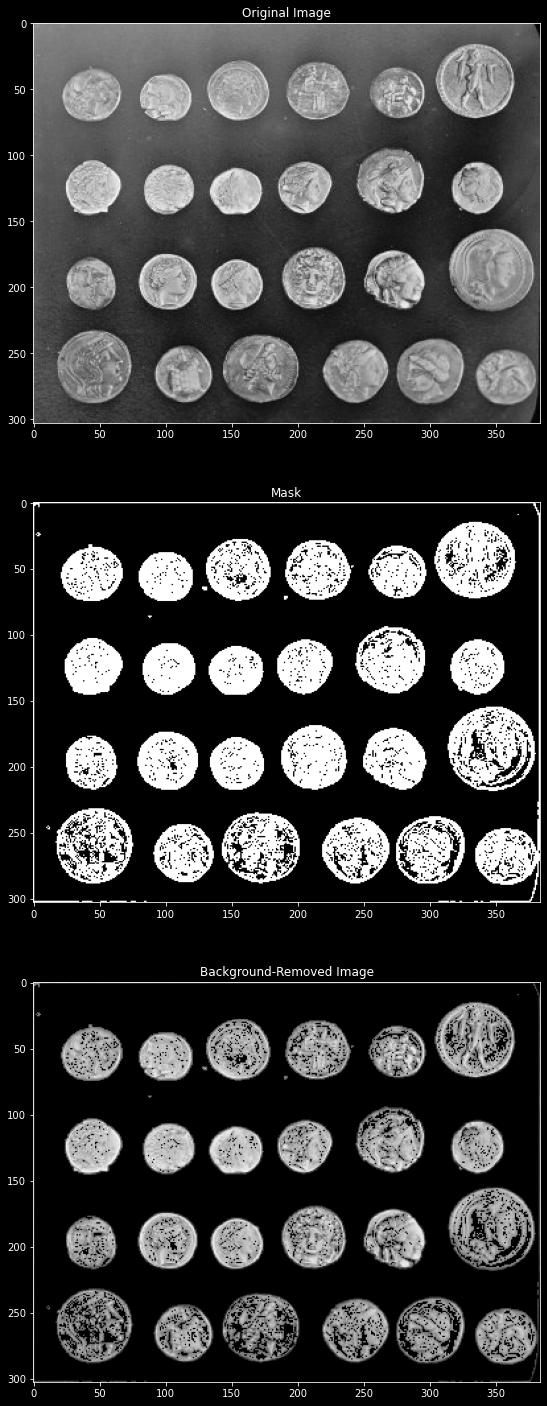

In [82]:
mask = (image_cluster == 3) + (image_cluster == 4)
new_image = np.zeros(image.shape)
new_image[mask] = image[mask]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 25))
axes[0].imshow(image, cmap="gray")
axes[0].title.set_text("Original Image")
axes[1].imshow(mask, cmap="gray")
axes[1].title.set_text("Mask")
axes[2].imshow(new_image, cmap="gray")
axes[2].title.set_text("Background-Removed Image")